In [42]:
import json
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
import torch
import torchvision.transforms as T

parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.image_handling import crop_image, pad_bbox
from utils.keypoints import crop_and_resize_keypoints
from utils.heatmap import generate_multi_gaussian_heatmaps, decode_heatmaps
from training.keypointnet import KeypointNet

In [43]:
BASE_PATH = Path("../../")

In [44]:
def load_sample(sample_path):
    with open(sample_path, 'r') as f:
        samples = json.load(f)
    return samples

def load_keypoints(keypoints_path):
    with open(keypoints_path, 'r') as f:
        data = json.load(f)
    keypoints = np.array(data['keypoints_3D'])
    return keypoints

In [45]:
def preprocess_image(image_path, bbox, target_size=(128, 128)):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = crop_image(img, bbox)
    resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_LINEAR)
    crop_tensor = torch.from_numpy(resized_img.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)
    return crop_tensor

In [ ]:
def draw_model_overlay(img, projected_pts, faces=None, color=(0, 255, 0)):
    img_overlay = img.copy()
    
    if faces is not None:
        # Draw mesh faces
        for face in faces:
            pts = projected_pts[face].astype(np.int32)
            cv2.polylines(img_overlay, [pts], isClosed=True, color=color, thickness=1)
    else:
        # Draw points only
        for (x, y) in projected_pts.astype(np.int32):
            cv2.circle(img_overlay, (x, y), 2, color, -1)

    return img_overlay

In [ ]:
from utils.keypoints import project_3D_points_to_2D
import trimesh

def draw_pose(img, model_path, R, t, K):
    mesh = trimesh.load(model_path)

    # Optional: scale vertices if model was in millimeters
    vertices = mesh.vertices.copy()
    if vertices.max() > 10:  # crude check if it's not already in meters
        vertices *= 0.001  # convert mm → meters

    faces = mesh.faces if hasattr(mesh, 'faces') else None

    projected_pts = project_3D_points_to_2D(vertices, R, t, K)
    overlay = draw_model_overlay(img, projected_pts, faces=faces)
    return overlay
    # plt.figure(figsize=(8, 8))
    # plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

In [46]:
def draw_axes(img, K, R, t, center_2D, axis_length=0.1):
    """
    img: background image (BGR)
    K: camera intrinsics (3,3)
    R: rotation matrix (3,3)
    t: translation vector (3,)
    center_2D: 2D pixel location (x, y) to anchor the axes
    axis_length: how long each axis is in meters
    """
    # Define axis endpoints in 3D object frame
    axis_3D = np.array([
        [0, 0, 0],              # origin
        [axis_length, 0, 0],    # X axis
        [0, axis_length, 0],    # Y axis
        [0, 0, axis_length]     # Z axis
    ])

    # Transform axes into camera frame
    axis_cam = (R @ axis_3D.T).T + t.reshape(1, 3)

    # Project to 2D
    points_proj = (K @ axis_cam.T).T
    points_proj = points_proj[:, :2] / points_proj[:, 2:3]  # (N, 2)

    # Shift so origin matches detected centroid (center_2D)
    offset = center_2D - points_proj[0]
    points_proj += offset

    # Draw lines
    img_axes = img.copy()
    origin = tuple(points_proj[0].astype(int))
    x_end = tuple(points_proj[1].astype(int))
    y_end = tuple(points_proj[2].astype(int))
    z_end = tuple(points_proj[3].astype(int))

    cv2.line(img_axes, origin, x_end, (0, 0, 255), 2)   # X axis in RED
    cv2.line(img_axes, origin, y_end, (0, 255, 0), 2)   # Y axis in GREEN
    cv2.line(img_axes, origin, z_end, (255, 0, 0), 2)   # Z axis in BLUE

    return img_axes


In [ ]:
from utils.evaluation import compute_pck, estimate_pose_pnp_ransac
from utils.keypoints import map_keypoints_to_original


def visualize_model_quality(obj_id, samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_KEYPOINTS = 15
    IMAGE_SIZE =(128, 128)
    keypoints_path = BASE_PATH / f"data/keypoints3d/{obj_id:06d}.json"
    MODEL_PATH = BASE_PATH / f"models/r6dnet/obj_{obj_id:06d}.pt"
    keypoints_3d = load_keypoints(keypoints_path)
    
    model = KeypointNet(
        num_keypoints=NUM_KEYPOINTS,
        output_size=IMAGE_SIZE,
    ).to(device)

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()

    # fig, axes = plt.subplots(2, len(samples), figsize=(5 * len(samples), 10))

    if len(samples) == 1:
        axes = [axes]

    for i, sample_entry in enumerate(samples):
        image_id = sample_entry['image_id']
        bbox =  pad_bbox(sample_entry['bbox_obj'])
        keypoints = np.array(sample_entry['keypoints_2D'])
        image_path = BASE_PATH / sample_entry['rgb_path']
        K = np.array(sample_entry['K'])
        R = np.array(sample_entry['rotation']).reshape(3, 3)
        t = np.array(sample_entry['translation']).reshape(3, 1)
        gt_keypoints = crop_and_resize_keypoints(keypoints, bbox, IMAGE_SIZE)
        # gt_heatmaps = generate_multi_gaussian_heatmaps(gt_keypoints, *IMAGE_SIZE, sigma=5)
        img = preprocess_image(image_path, bbox).to(device)

        with torch.no_grad():
            heatmaps = model(img)
            heatmaps_np = heatmaps.cpu().numpy()[0]
            decoded_keypoints = decode_heatmaps(heatmaps_np)
            pred_keypoints_orig = map_keypoints_to_original(decoded_keypoints, bbox, IMAGE_SIZE)
            pred_keypoints_orig = np.array(pred_keypoints_orig)
            # print(pred_keypoints_orig)
            # print(keypoints)
            
            # pck = compute_pck(pred_keypoints_orig, gt_keypoints_2D, threshold=5.0)
            
        try:
            rvec, tvec = estimate_pose_pnp_ransac(keypoints_3d, pred_keypoints_orig, K)
            R_pred, _ = cv2.Rodrigues(rvec)
        except RuntimeError:
            continue
        # print(R_pred)
        # print(tvec)
            
        # axes[0][i].imshow(img.cpu().numpy()[0].transpose(1, 2, 0))
        # axes[0][i].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='red', label='GT', s=50, marker='x')
        # axes[0][i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='blue', label='GT', s=50, marker='+')
        # axes[0][i].set_title(f"Sample {image_id}")
        # axes[0][i].axis('off')

        # axes[1][i].imshow(heatmaps_np.sum(axis=0), cmap='jet')
        # axes[1][i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='red', label='Decoded', s=30, marker='o')
        # axes[1][i].axis('off')

        raw_img = cv2.imread(str(image_path))
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

        # axes[1,i].imshow(raw_img)
        model_3f_path = BASE_PATH / f"datasets/lm/models/obj_{obj_id:06d}.ply"
        img_with_axes = draw_axes(raw_img, K, R_pred, tvec, pred_keypoints_orig[0])
        img_with_axes = draw_pose(raw_img, R_pred, tvec, pred_keypoints_orig[0], model_3f_path)

        plt.imshow(img_with_axes)
        # axes[1][i].scatter(keypoints[:, 0], keypoints[:, 1], c='red', label='GT', s=50, marker='x')
        # axes[1][i].scatter(pred_keypoints_orig[:, 0], pred_keypoints_orig[:, 1], c='red', label='Decoded', s=30, marker='o')
        # axes[2, i].axis('off')
        plt.tight_layout()
        plt.show()



[[391.5625   302.453125]
 [387.265625 287.5     ]
 [407.1875   325.109375]
 [386.875    289.3125  ]
 [380.234375 316.046875]
 [380.625    310.15625 ]
 [406.796875 302.      ]
 [379.84375  291.125   ]
 [375.9375   294.296875]
 [397.8125   317.859375]
 [388.828125 323.296875]
 [391.171875 294.296875]
 [373.984375 299.734375]
 [403.28125  287.046875]
 [399.765625 305.171875]]
[[389.75860808 301.4500406 ]
 [386.60485091 285.94318663]
 [408.08477614 326.94006141]
 [387.5742307  290.28340721]
 [379.18126853 315.96970706]
 [377.57744091 309.74879833]
 [405.90006055 301.73829857]
 [401.78570035 289.82634252]
 [374.29505422 293.30079384]
 [400.2425603  319.05036067]
 [388.36660937 322.70109993]
 [388.74429992 294.91831143]
 [370.90329652 297.30477706]
 [404.93190982 285.7336692 ]
 [399.09257398 304.3379672 ]]
[[ 0.75492139  0.56042612 -0.3406116 ]
 [ 0.32488284 -0.77074633 -0.54808871]
 [-0.56968837  0.30310503 -0.76392572]]
[[0.11487552]
 [0.09974102]
 [1.01211304]]
[[215.234375  296.546875 ]


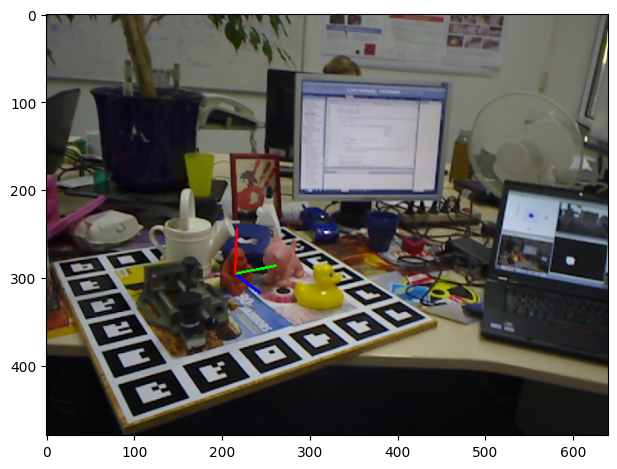

In [71]:
obj_id = 1  # Change as needed
sample_path = BASE_PATH / f"data/annotations/test/{obj_id:06d}.json"
samples = load_sample(sample_path)

# Randomly select 3 samples
random.seed(42)
selected_samples = random.sample(samples, 2)
visualize_model_quality(obj_id, selected_samples)